<a href="https://colab.research.google.com/github/LatiefDataVisionary/data-science-capstone-project-college/blob/main/notebooks/04_programmatic_labeling_bilingual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **04 Programmatic Sentiment Labeling (Bilingual)**

This notebook performs programmatic sentiment labeling on a clean, unlabeled, bilingual (English & Indonesian) dataset. It employs a hybrid, language-specific approach:

- For English reviews, it utilizes the fast, lexicon-based VADER tool.
- For Indonesian reviews, it leverages a powerful, pre-trained Transformer-based model fine-tuned for Indonesian sentiment.

The input is the cleaned dataset, and the output is a single, consistently labeled dataset.

## **1. Setup and Data Loading**

In [1]:
# Install necessary libraries
!pip install langdetect transformers[torch] tqdm langid Sastrawi accelerate -qqq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 23.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 28.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 16.2 MB/s eta 0:00:00


In [2]:
# This cell is now redundant as library installation is included in 021490ff
# Kept for now but can be removed later.

In [3]:
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch
from tqdm.auto import tqdm
from langdetect import detect, DetectorFactory
from huggingface_hub import login
from google.colab import userdata
import os
import re
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory # Import Sastrawi Stemmer

# Ensure consistent language detection results for langdetect
DetectorFactory.seed = 0

tqdm.pandas()

In [4]:
# This cell is now redundant as vader_lexicon download is included in Xt7x9RkLdscb
# Kept for now but can be removed later.

In [5]:
# Download necessary NLTK data
try:
    nltk.data.find('sentiment/vader_lexicon.zip')
except LookupError:
    nltk.download('vader_lexicon')

try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

try:
    nltk.data.find('corpora/wordnet')
except LookupError:
     nltk.download('wordnet')

try:
    nltk.data.find('corpora/omw-1.4')
except LookupError:
     nltk.download('omw-1.4')

print("NLTK data download complete.")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


NLTK data download complete.


In [6]:
# Commented out as loading is handled in cell 1994c3eb
# reviews_cleaned_en = 'https://raw.githubusercontent.com/LatiefDataVisionary/data-science-capstone-project-college/refs/heads/main/data/processed/reviews_cleaned_en.csv'
# reviews_cleaned_id = 'https://raw.githubusercontent.com/LatiefDataVisionary/data-science-capstone-project-college/refs/heads/main/data/processed/reviews_cleaned_id.csv'

In [7]:
# Commented out as loading is handled in cell 1994c3eb
# reviews_cleaned_en = 'https://raw.githubusercontent.com/LatiefDataVisionary/data-science-capstone-project-college/refs/heads/main/data/processed/reviews_cleaned_en_tokenized.csv'
# reviews_cleaned_id = 'https://raw.githubusercontent.com/LatiefDataVisionary/data-science-capstone-project-college/refs/heads/main/data/processed/reviews_cleaned_id_tokenized.csv'

In [8]:
# Load the cleaned datasets separately
reviews_cleaned_en = 'https://raw.githubusercontent.com/LatiefDataVisionary/data-science-capstone-project-college/refs/heads/main/data/processed/reviews_cleaned_en_tokenized.csv'
# reviews_cleaned_id = 'https://raw.githubusercontent.com/LatiefDataVisionary/data-science-capstone-project-college/refs/heads/main/data/processed/reviews_cleaned_id_tokenized.csv'
reviews_raw_id = 'https://raw.githubusercontent.com/LatiefDataVisionary/data-science-capstone-project-college/refs/heads/main/data/raw/combined-raw-dataset/spotify_reviews_indonesian_combine.csv'
# because the bert model doest need the stop word removal in the preprocessing step, so i drop the preprocessing codes just for the indonesian reviews without stop word removal and using the raw indonesian reviews dataset

try:
    df_en = pd.read_csv(reviews_cleaned_en)
    print(f"English data loaded from {reviews_cleaned_en}.")
except Exception as e:
    print(f"Error loading English data: {e}")
    df_en = pd.DataFrame() # Create an empty DataFrame in case of error

try:
    # df_id = pd.read_csv(reviews_cleaned_id)
    df_id = pd.read_csv(reviews_raw_id)
    print(f"Indonesian data loaded from {reviews_raw_id}.")
except Exception as e:
    print(f"Error loading Indonesian data: {e}")
    df_id = pd.DataFrame() # Create an empty DataFrame in case of error

# Display the heads of the separate dataframes to confirm loading
print("\nEnglish DataFrame head:")
display(df_en.head())

print("\nIndonesian DataFrame head:")
display(df_id.head())

English data loaded from https://raw.githubusercontent.com/LatiefDataVisionary/data-science-capstone-project-college/refs/heads/main/data/processed/reviews_cleaned_en_tokenized.csv.
Indonesian data loaded from https://raw.githubusercontent.com/LatiefDataVisionary/data-science-capstone-project-college/refs/heads/main/data/raw/combined-raw-dataset/spotify_reviews_indonesian_combine.csv.

English DataFrame head:


,content,score,thumbsUpCount,cleaned_content
0,"they fixed it, I was just really pissy yesterd...",5,1,"['fixed', 'really', 'pissy', 'yesterday', 'cau..."
1,"Offline doesnt work, support doesnt help, just...",1,0,"['offline', 'doesnt', 'work', 'support', 'does..."
2,Super annoying ad experience! It feels like th...,1,5,"['super', 'annoying', 'ad', 'experience', 'fee..."
3,👍,5,1,[]
4,super song for everything,5,0,"['super', 'song', 'everything']"



Indonesian DataFrame head:


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,language,char_length,word_count,review_month
0,427e2299-b27a-4f53-89ac-15f9885207c8,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,lagu bukan hanya alunan nada tapi bisa jadi un...,1,2,NaN,2025-09-28 05:29:11,NaN,NaN,NaN,Indonesian,91,14,2025-09
1,790cee66-b937-41ba-b7a8-e831c60f63a4,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,iklan Mulu gak jelass apa apa harus premium ko...,1,0,9.0.82.1032,2025-09-28 03:08:45,NaN,NaN,9.0.82.1032,Indonesian,50,9,2025-09
2,2a59f6d0-fa47-4e26-b097-9ef0ddc824f6,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Terima kasih banyak 🙏👍👍👍,5,0,NaN,2025-09-27 06:05:37,NaN,NaN,NaN,Indonesian,24,4,2025-09
3,0d356a00-bd64-4539-a23f-aaa7e46c98d8,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,kok di aku mah gk bisa ada lirik ya sih tolong...,4,0,9.0.82.1032,2025-09-27 06:03:26,NaN,NaN,9.0.82.1032,Indonesian,116,19,2025-09
4,0349c341-fad0-4e60-8952-28dc1cb43659,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,sangat banyak lagu nya,5,0,9.0.80.1343,2025-09-27 05:56:16,NaN,NaN,9.0.80.1343,Indonesian,22,4,2025-09


## **2. Preprocessing for Indonesian Reviews Dataset**

### **2.1: Lowercasing**


In [9]:
df_id['cleaned_content'] = df_id['content'].str.lower()
print("Indonesian text converted to lowercase.")
display(df_id[['content', 'cleaned_content']].head())

Indonesian text converted to lowercase.


,content,cleaned_content
0,lagu bukan hanya alunan nada tapi bisa jadi un...,lagu bukan hanya alunan nada tapi bisa jadi un...
1,iklan Mulu gak jelass apa apa harus premium ko...,iklan mulu gak jelass apa apa harus premium ko...
2,Terima kasih banyak 🙏👍👍👍,terima kasih banyak 🙏👍👍👍
3,kok di aku mah gk bisa ada lirik ya sih tolong...,kok di aku mah gk bisa ada lirik ya sih tolong...
4,sangat banyak lagu nya,sangat banyak lagu nya


### **2.2: Removing URLs**


In [10]:
# Define the URL pattern
url_pattern = re.compile(r'https?://\S+|www\.\S+')

df_id['cleaned_content'] = df_id['cleaned_content'].apply(lambda x: url_pattern.sub(r'', str(x)))
print("URLs removed from Indonesian DataFrame.")
display(df_id[['content', 'cleaned_content']].head())

URLs removed from Indonesian DataFrame.


,content,cleaned_content
0,lagu bukan hanya alunan nada tapi bisa jadi un...,lagu bukan hanya alunan nada tapi bisa jadi un...
1,iklan Mulu gak jelass apa apa harus premium ko...,iklan mulu gak jelass apa apa harus premium ko...
2,Terima kasih banyak 🙏👍👍👍,terima kasih banyak 🙏👍👍👍
3,kok di aku mah gk bisa ada lirik ya sih tolong...,kok di aku mah gk bisa ada lirik ya sih tolong...
4,sangat banyak lagu nya,sangat banyak lagu nya


### **2.3: Removing Unnecessary Characters**


In [11]:
alpha_pattern = re.compile(r'[^a-z\s]')
df_id['cleaned_content'] = df_id['cleaned_content'].apply(lambda x: alpha_pattern.sub(r'', str(x)))
print("Unnecessary characters removed from Indonesian DataFrame.")
display(df_id[['content', 'cleaned_content']].head())

Unnecessary characters removed from Indonesian DataFrame.


,content,cleaned_content
0,lagu bukan hanya alunan nada tapi bisa jadi un...,lagu bukan hanya alunan nada tapi bisa jadi un...
1,iklan Mulu gak jelass apa apa harus premium ko...,iklan mulu gak jelass apa apa harus premium ko...
2,Terima kasih banyak 🙏👍👍👍,terima kasih banyak
3,kok di aku mah gk bisa ada lirik ya sih tolong...,kok di aku mah gk bisa ada lirik ya sih tolong...
4,sangat banyak lagu nya,sangat banyak lagu nya


### **2.4: Removing Extra Whitespace**


In [12]:
df_id['cleaned_content'] = df_id['cleaned_content'].str.strip()
# Replace multiple spaces with a single space
df_id['cleaned_content'] = df_id['cleaned_content'].str.replace(r'\s+', ' ', regex=True)
print("Extra whitespace removed from Indonesian DataFrame.")
display(df_id[['content', 'cleaned_content']].head())

Extra whitespace removed from Indonesian DataFrame.


,content,cleaned_content
0,lagu bukan hanya alunan nada tapi bisa jadi un...,lagu bukan hanya alunan nada tapi bisa jadi un...
1,iklan Mulu gak jelass apa apa harus premium ko...,iklan mulu gak jelass apa apa harus premium ko...
2,Terima kasih banyak 🙏👍👍👍,terima kasih banyak
3,kok di aku mah gk bisa ada lirik ya sih tolong...,kok di aku mah gk bisa ada lirik ya sih tolong...
4,sangat banyak lagu nya,sangat banyak lagu nya


### **2.5: Tokenization**


In [13]:
# Apply tokenization to Indonesian reviews using simple whitespace split
df_id['cleaned_content_tokens'] = df_id['cleaned_content'].apply(lambda x: str(x).split())
print("Indonesian text tokenized using whitespace splitting.")
display(df_id[['content', 'cleaned_content', 'cleaned_content_tokens']].head())

Indonesian text tokenized using whitespace splitting.


,content,cleaned_content,cleaned_content_tokens
0,lagu bukan hanya alunan nada tapi bisa jadi un...,lagu bukan hanya alunan nada tapi bisa jadi un...,"[lagu, bukan, hanya, alunan, nada, tapi, bisa,..."
1,iklan Mulu gak jelass apa apa harus premium ko...,iklan mulu gak jelass apa apa harus premium ko...,"[iklan, mulu, gak, jelass, apa, apa, harus, pr..."
2,Terima kasih banyak 🙏👍👍👍,terima kasih banyak,"[terima, kasih, banyak]"
3,kok di aku mah gk bisa ada lirik ya sih tolong...,kok di aku mah gk bisa ada lirik ya sih tolong...,"[kok, di, aku, mah, gk, bisa, ada, lirik, ya, ..."
4,sangat banyak lagu nya,sangat banyak lagu nya,"[sangat, banyak, lagu, nya]"


In [14]:
df_id['cleaned_content'] = df_id['cleaned_content_tokens']
df_id['cleaned_content']

,cleaned_content
0,"[lagu, bukan, hanya, alunan, nada, tapi, bisa,..."
1,"[iklan, mulu, gak, jelass, apa, apa, harus, pr..."
2,"[terima, kasih, banyak]"
3,"[kok, di, aku, mah, gk, bisa, ada, lirik, ya, ..."
4,"[sangat, banyak, lagu, nya]"
...,...
59241,"[sangat, senang, bisa, request, lagu, dgn, cep..."
59242,"[bagus, banget, ahhh, suka, dengerin, lagu, se..."
59243,"[aplikasi, bagus, kali, tapi, gw, lebih, suka,..."
59244,"[lagu, lagunya, sangat, bagus, dari, yang, lam..."


### **2.6: Normalization of Indonesian Slang (Kamus Alay)**


In [15]:
if df_id is not None and not df_id.empty:
    # Example slang dictionary (this is a small sample)
    slang_dict = {
        'ga': 'tidak', 'gak': 'tidak', 'nggak': 'tidak',
        'bgt': 'banget', 'bangett': 'banget',
        'yg': 'yang', 'iy': 'iya', 'aja': 'saja',
        'udh': 'sudah', 'dah': 'sudah',
        'kt': 'kita', 'dr': 'dari',
        'untukku': 'untuk saya', # Example of possessive normalization if needed
        'makin': 'semakin',
        'trs': 'terus'
        # Add more slang words and their formal equivalents here
    }

    # Function to normalize Indonesian slang
    def normalize_slang(text, slang_dictionary):
        if not text: # Check if the input text (list of tokens) is empty or None
            return [] # Return an empty list if the input is empty

        # Ensure words is a list of strings, handle cases where input might not be a list
        words = text if isinstance(text, list) else str(text).split()

        normalized_words = [slang_dictionary.get(word, word) for word in words]
        return normalized_words # Return as a list of tokens

    # Apply slang normalization to Indonesian reviews
    df_id['cleaned_content'] = df_id.apply(lambda row: normalize_slang(row['cleaned_content'], slang_dict), axis=1)
    print("Indonesian slang normalized (using a small dictionary).")
    display(df_id[['content', 'cleaned_content', 'language']].head())
else:
    print("Indonesian DataFrame is empty or None. Skipping slang normalization.")

Indonesian slang normalized (using a small dictionary).


,content,cleaned_content,language
0,lagu bukan hanya alunan nada tapi bisa jadi un...,"[lagu, bukan, hanya, alunan, nada, tapi, bisa,...",Indonesian
1,iklan Mulu gak jelass apa apa harus premium ko...,"[iklan, mulu, tidak, jelass, apa, apa, harus, ...",Indonesian
2,Terima kasih banyak 🙏👍👍👍,"[terima, kasih, banyak]",Indonesian
3,kok di aku mah gk bisa ada lirik ya sih tolong...,"[kok, di, aku, mah, gk, bisa, ada, lirik, ya, ...",Indonesian
4,sangat banyak lagu nya,"[sangat, banyak, lagu, nya]",Indonesian


## **2. Language Detection: The Core Logic Gate**

The first crucial step is to reliably detect the language of each review. This will act as a switch to direct the review to the correct labeling pipeline, ensuring that English reviews are processed by VADER and Indonesian reviews by the Transformer model. A robust language detection library is essential for this task.

In [16]:
# # Function to detect language with error handling
# def detect_language(text):
#     try:
#         # Langdetect can struggle with very short texts
#         if pd.isna(text) or len(str(text).strip()) < 5:
#             return 'unknown'
#         return detect(str(text))
#     except:
#         return 'unknown' # Handle potential errors during detection

# # Apply language detection
# df['language'] = df['content'].progress_apply(detect_language)

In [17]:
# # Show the distribution of detected languages
# display(df['language'].value_counts())

## **3. Pipeline A - Labeling English Reviews with VADER**

For English reviews, we will use VADER (Valence Aware Dictionary and sEntiment Reasoner). VADER is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media, and it is known for being fast and effective for English text. It provides a compound score ranging from -1 (most negative) to +1 (most positive).

In [18]:
# Initialize the VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

In [19]:
# Function to label English sentiment using VADER compound score
def label_english_sentiment(text):
    if pd.isna(text):
        return None
    scores = sia.polarity_scores(str(text))
    compound_score = scores['compound']
    if compound_score >= 0.03:
        return 'positive'
    elif compound_score <= -0.02:
        return 'negative'
    else:
        return 'neutral'

In [20]:
# Apply VADER labeling to English reviews
# Initialize sentiment_label column to None in df_en
df_en['sentiment_label'] = None

# Apply the labeling function to English reviews in df_en
df_en['sentiment_label'] = df_en['content'].progress_apply(label_english_sentiment)

# Check how many English reviews were labeled
print(f"Number of English reviews labeled: {df_en['sentiment_label'].notna().sum()}")

# Display a few examples of English reviews and their VADER-generated labels
print("\nExamples of English reviews and their VADER labels:")
display(df_en[['content', 'sentiment_label']].head())

  0%|          | 0/77078 [00:00<?, ?it/s]

Number of English reviews labeled: 77074

Examples of English reviews and their VADER labels:


,content,sentiment_label
0,"they fixed it, I was just really pissy yesterd...",neutral
1,"Offline doesnt work, support doesnt help, just...",negative
2,Super annoying ad experience! It feels like th...,positive
3,👍,neutral
4,super song for everything,positive


## **4. Pipeline B - Labeling Indonesian Reviews with a Transformer Model**

For Indonesian reviews, a more sophisticated, context-aware model is needed as VADER is not designed for this language. We will use a pre-trained Transformer model that has been fine-tuned for Indonesian sentiment analysis. This type of model captures nuances in language more effectively than lexicon-based methods for complex languages.

In [21]:
# Ambil token dari Colab Secrets
# Pastikan nama secret-nya adalah 'HF_TOKEN'
hf_token = userdata.get('HF_TOKEN')

# Lakukan login
login(token=hf_token)

print("Login Hugging Face berhasil!")

Login Hugging Face berhasil!


In [22]:
# Define the model checkpoint for an Indonesian sentiment model
# Using "w11wo/indonesian-roberta-base-sentiment-classifier" with pipeline.
# If you encounter issues loading the model, ensure you are authenticated with Hugging Face
# (e.g., by setting a HF_TOKEN in Colab secrets) or try a different public model.
model_checkpoint = "w11wo/indonesian-roberta-base-sentiment-classifier"
# model_checkpoint = "mdhugol/indonesia-bert-sentiment-classification"

# Load the sentiment analysis pipeline
try:
    sentiment_pipeline = pipeline("sentiment-analysis", model=model_checkpoint)
    print(f"Pipeline loaded successfully using model: {model_checkpoint}")
except Exception as e:
    print(f"Error loading pipeline with model {model_checkpoint}: {e}")
    sentiment_pipeline = None # Set to None if loading fails

# Define a simple mapping for labels if needed (check model card for exact labels)
# This model typically outputs 'LABEL_0', 'LABEL_1', 'LABEL_2'
# You might need to inspect the model output or model card to map these to 'negative', 'neutral', 'positive'
# For now, let's assume a common mapping or inspect the output later.
# Based on the model card, LABEL_0=negative, LABEL_1=neutral, LABEL_2=positive
id_label_mapping = {'LABEL_0': 'negative', 'LABEL_1': 'neutral', 'LABEL_2': 'positive'}

config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/328 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cuda:0


Pipeline loaded successfully using model: w11wo/indonesian-roberta-base-sentiment-classifier


### Tutorial: Menghubungkan Token Hugging Face ke Google Colab

Untuk dapat mengakses model-model tertentu di Hugging Face dari Google Colab, terutama jika model tersebut memerlukan autentikasi, Anda perlu menghubungkan token akses Hugging Face Anda ke lingkungan Colab. Cara paling aman adalah dengan menggunakan fitur **Colab Secrets**.

Berikut langkah-langkahnya:

1.  **Dapatkan Token Akses dari Hugging Face:**
    *   Buka website Hugging Face: [huggingface.co](https://huggingface.co/)
    *   Login ke akun Hugging Face Anda. Jika belum punya, daftar terlebih dahulu.
    *   Setelah login, klik **foto profil Anda** di kanan atas halaman.
    *   Pilih **"Settings"** dari menu dropdown.
    *   Di menu navigasi sebelah kiri pada halaman Settings, klik **"Access Tokens"**.
    *   Klik tombol **"New token"** untuk membuat token baru.
    *   Beri nama token Anda (misalnya, `colab-access`, `my-project-token`, dll.). Nama ini hanya untuk identifikasi di akun Hugging Face Anda.
    *   Pilih peran (Role) token: Untuk memuat model, peran **"read"** sudah cukup. Jika Anda berencana mengunggah sesuatu, pilih "write".
    *   Klik tombol **"Generate token"**.
    *   Token akan muncul di layar. **Salin token ini segera** karena Anda tidak akan bisa melihatnya lagi nanti. Simpan di tempat yang aman sementara jika perlu, tapi jangan masukkan langsung ke kode notebook yang akan dibagikan.

2.  **Simpan Token di Google Colab Secrets:**
    *   Kembali ke Google Colab notebook Anda.
    *   Di sidebar kiri Colab, temukan dan klik ikon **Kunci (🔒)**. Ini adalah panel Secrets.
    *   Klik tombol **"+ New secret"**.
    *   Pada kolom **"Name"**, masukkan nama secret Anda. **Sangat penting** untuk menggunakan nama yang akan Anda panggil di kode. Dalam kasus notebook ini, kita menggunakan nama **`HF_TOKEN`**. Jadi, ketik `HF_TOKEN`.
    *   Pada kolom **"Value"**, tempel (paste) token akses Hugging Face yang baru saja Anda salin.
    *   Pastikan tombol **"Notebook access"** diaktifkan (berwarna hijau atau tercentang). Ini memungkinkan notebook Anda mengakses secret ini.
    *   (Opsional) Anda bisa menambahkan deskripsi untuk secret ini.
    *   Setelah selesai, secret akan tersimpan secara otomatis.

3.  **Gunakan Token di Kode Colab untuk Login:**
    *   Sekarang, Anda bisa menggunakan kode Python di notebook Anda untuk mengambil secret `HF_TOKEN` dan melakukan login ke Hugging Face. Kode ini akan mengambil token dari Colab Secrets, bukan dari kode yang terlihat, sehingga lebih aman.

Berikut kode Python yang perlu Anda jalankan di notebook Anda (ini adalah sel yang sebelumnya error `SecretNotFoundError`):

In [23]:
# # Define the tokenizer and model globally
# # Note: If you encounter OSError here, it might be a temporary issue with Hugging Face servers
# # or a problem accessing the model files. Try running the cell again later.
# # Also, double-check the model name on Hugging Face.
# tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
# model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint)

# # Define the label mapping globally
# id_labels = ['negative', 'neutral', 'positive'] # Based on the model card: LABEL_0=negative, LABEL_1=neutral, LABEL_2=positive

# # Function to label Indonesian sentiment using the Transformer model
# def label_indonesian_sentiment(text):
#     if pd.isna(text):
#         return None
#     try:
#         # Tokenize the text
#         inputs = tokenizer(str(text), return_tensors="pt", truncation=True, padding=True, max_length=512)

#         # Pass the tokens through the model
#         with torch.no_grad():
#             outputs = model(**inputs)

#         # Get the logits and apply softmax to get probabilities
#         logits = outputs.logits
#         probabilities = torch.softmax(logits, dim=1)[0]

#         # Determine the predicted label (index with the highest probability)
#         predicted_class_id = probabilities.argmax().item()

#         # Return the corresponding label
#         return id_labels[predicted_class_id]

#     except Exception as e:
#         print(f"Error labeling text: {text[:50]}... Error: {e}")
#         return None # Return None if labeling fails

In [26]:
# Define the tokenizer and model globally
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint)

# Define the label mapping globally
id_labels = ['negative', 'neutral', 'positive'] # Based on the model card: LABEL_0=negative, LABEL_1=neutral, LABEL_2=positive

# Function to label Indonesian sentiment using the Transformer model
def label_indonesian_sentiment(text):
    # Check if the input is None or an empty list
    if text is None or (isinstance(text, list) and not text):
        return None
    try:
        # Tokenize the text. Join the list of tokens back into a string.
        text_str = " ".join(text) if isinstance(text, list) else str(text)
        inputs = tokenizer(text_str, return_tensors="pt", truncation=True, padding=True, max_length=512)

        # Pass the tokens through the model
        with torch.no_grad():
            outputs = model(**inputs)

        # Get the logits and apply softmax to get probabilities
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)[0]

        # Determine the predicted label (index with the highest probability)
        predicted_class_id = probabilities.argmax().item()

        # Return the corresponding label
        return id_labels[predicted_class_id]

    except Exception as e:
        print(f"Error labeling text: {text[:50]}... Error: {e}")
        return None # Return None if labeling fails

In [27]:
# Apply Transformer labeling to Indonesian reviews
# Initialize sentiment_label column to None in df_id
df_id['sentiment_label'] = None

# Apply Transformer labeling to Indonesian reviews
df_id['sentiment_label'] = df_id['cleaned_content'].progress_apply(label_indonesian_sentiment)

# Check how many Indonesian reviews were labeled
print(f"Number of Indonesian reviews labeled: {df_id['sentiment_label'].notna().sum()}")

# Display a few examples of Indonesian reviews and their Transformer-generated labels
print("\nExamples of Indonesian reviews and their Transformer labels:")
display(df_id[['content', 'sentiment_label']].head())

  0%|          | 0/59246 [00:00<?, ?it/s]

Number of Indonesian reviews labeled: 58204

Examples of Indonesian reviews and their Transformer labels:


,content,sentiment_label
0,lagu bukan hanya alunan nada tapi bisa jadi un...,negative
1,iklan Mulu gak jelass apa apa harus premium ko...,positive
2,Terima kasih banyak 🙏👍👍👍,negative
3,kok di aku mah gk bisa ada lirik ya sih tolong...,positive
4,sangat banyak lagu nya,negative


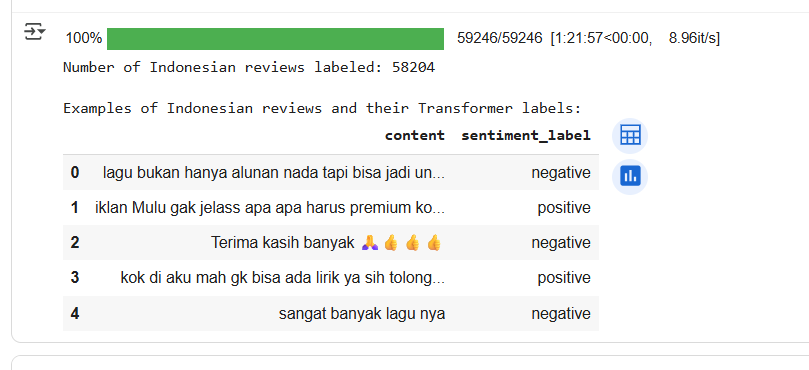

In [ ]:
# # Apply Transformer labeling to Indonesian reviews
# # Initialize sentiment_label column to None in df_id
# df_id['sentiment_label'] = None

# # Apply Transformer labeling to Indonesian reviews
# df_id['sentiment_label'] = df_id['cleaned_content'].progress_apply(label_indonesian_sentiment)

# # Check how many Indonesian reviews were labeled
# print(f"Number of Indonesian reviews labeled: {df_id['sentiment_label'].notna().sum()}")

# # Display a few examples of Indonesian reviews and their Transformer-generated labels
# print("\nExamples of Indonesian reviews and their Transformer labels:")
# display(df_id[['content', 'sentiment_label']].head())

In [31]:
df_id[['content', 'sentiment_label']].head(100)

,content,sentiment_label
0,lagu bukan hanya alunan nada tapi bisa jadi un...,negative
1,iklan Mulu gak jelass apa apa harus premium ko...,positive
2,Terima kasih banyak 🙏👍👍👍,negative
3,kok di aku mah gk bisa ada lirik ya sih tolong...,positive
4,sangat banyak lagu nya,negative
...,...,...
95,👍,None
96,"suka error kalau ga update, aneh tolong diperb...",positive
97,top & terbaik👍,negative
98,enak tapi terkadang harus premium dulu terus d...,positive


In [32]:
# Map the sentiment labels to reverse them for Indonesian reviews
label_reverse_mapping = {
    'positive': 'negative',
    'neutral': 'neutral',  # Neutral stays neutral
    'negative': 'positive'
}

# Apply the reverse mapping to the 'sentiment_label' column in df_id
df_id['sentiment_label'] = df_id['sentiment_label'].map(label_reverse_mapping)

print("Sentiment labels for Indonesian reviews have been reversed.")
display(df_id[['content', 'sentiment_label']].head(20))

Sentiment labels for Indonesian reviews have been reversed.


,content,sentiment_label
0,lagu bukan hanya alunan nada tapi bisa jadi un...,positive
1,iklan Mulu gak jelass apa apa harus premium ko...,negative
2,Terima kasih banyak 🙏👍👍👍,positive
3,kok di aku mah gk bisa ada lirik ya sih tolong...,negative
4,sangat banyak lagu nya,positive
5,"sngt bagusss sekali,apalagi kalo musik koleksi...",positive
6,very good i like it but why do i have to pay? ...,negative
7,baik,positive
8,"apk pemutar lagu paling bagus menurut ku,, tin...",positive
9,Tnks spotify musik sudah memberi yang terbaik ...,positive


In [33]:
display(df_id[['content', 'sentiment_label']].head(1000))

,content,sentiment_label
0,lagu bukan hanya alunan nada tapi bisa jadi un...,positive
1,iklan Mulu gak jelass apa apa harus premium ko...,negative
2,Terima kasih banyak 🙏👍👍👍,positive
3,kok di aku mah gk bisa ada lirik ya sih tolong...,negative
4,sangat banyak lagu nya,positive
...,...,...
995,gatau,positive
996,"seru,cocok banget kalo lagi galau pas banget n...",positive
997,bagus banget👍,positive
998,"bug ny tolong di perbaiki, setiap masuk atau p...",negative


## **5. Reviewing and Finalizing the Labeled Dataset**

In [35]:
# Check for any reviews that were not labeled
unlabeled_count_en = df_en['sentiment_label'].isnull().sum()
unlabeled_count_id = df_id['sentiment_label'].isnull().sum()
total_unlabeled_count = unlabeled_count_en + unlabeled_count_id

print(f"Number of English reviews that were not labeled: {unlabeled_count_en}")
print(f"Number of Indonesian reviews that were not labeled: {unlabeled_count_id}")
print(f"Total number of reviews that were not labeled: {total_unlabeled_count}")

if total_unlabeled_count > 0:
    print("Check the language detection results for these reviews, or if any errors occurred during labeling.")

Number of English reviews that were not labeled: 4
Number of Indonesian reviews that were not labeled: 1042
Total number of reviews that were not labeled: 1046
Check the language detection results for these reviews, or if any errors occurred during labeling.


In [36]:
# Display the final distribution of the combined labels
# display(df['sentiment_label'].value_counts())

# Combine the sentiment labels from both dataframes for a combined distribution
combined_sentiment_labels = pd.concat([df_en['sentiment_label'], df_id['sentiment_label']])
display(combined_sentiment_labels.value_counts())

,count
sentiment_label,
positive,98946
negative,24417
neutral,11915


In [37]:
# Display a few examples of English reviews and their VADER-generated labels
print("Examples of English reviews and their VADER labels:")
# display(df[df['language'] == 'en'][['content', 'sentiment_label']].head())
display(df_en[['content', 'sentiment_label']].head())

Examples of English reviews and their VADER labels:


,content,sentiment_label
0,"they fixed it, I was just really pissy yesterd...",neutral
1,"Offline doesnt work, support doesnt help, just...",negative
2,Super annoying ad experience! It feels like th...,positive
3,👍,neutral
4,super song for everything,positive


In [38]:
# Display a few examples of Indonesian reviews and their Transformer-generated labels
print("\nExamples of Indonesian reviews and their Transformer labels:")
# display(df[df['language'] == 'id'][['content', 'sentiment_label']].head())
display(df_id[['content', 'sentiment_label']].head())


Examples of Indonesian reviews and their Transformer labels:


,content,sentiment_label
0,lagu bukan hanya alunan nada tapi bisa jadi un...,positive
1,iklan Mulu gak jelass apa apa harus premium ko...,negative
2,Terima kasih banyak 🙏👍👍👍,positive
3,kok di aku mah gk bisa ada lirik ya sih tolong...,negative
4,sangat banyak lagu nya,positive


## **6. Saving the Labeled Dataset**

In [39]:
# Define the output directory and filenames
output_dir = '../data/processed/'
# output_path_en = os.path.join(output_dir, 'reviews_labeled_en.csv')
# output_path_id = os.path.join(output_dir, 'reviews_labeled_id.csv')
output_path_en = os.path.join(output_dir, 'reviews_labeled_en_tokenized.csv')
output_path_id = os.path.join(output_dir, 'reviews_labeled_id_tokenized.csv')

# output_path_other = os.path.join(output_dir, 'reviews_labeled_other_languages.csv') # To save other languages

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
print(f"Output directory '{output_dir}' ensured to exist.")

# # Filter the DataFrame by language - this is no longer needed as we have separate dataframes
# df_en_labeled = df[df['language'] == 'en']
# df_id_labeled = df[df['language'] == 'id']
# df_other_languages = df[~df['language'].isin(['en', 'id'])]


# Save the labeled DataFrames to separate CSV files
try:
    df_en.to_csv(output_path_en, index=False)
    print(f"Labeled English dataset saved to {output_path_en}")
except Exception as e:
    print(f"Error saving English dataset: {e}")

try:
    df_id.to_csv(output_path_id, index=False)
    print(f"Labeled Indonesian dataset saved to {output_path_id}")
except Exception as e:
    print(f"Error saving Indonesian dataset: {e}")

# try:
#     df_other_languages.to_csv(output_path_other, index=False)
#     print(f"Labeled other languages dataset saved to {output_path_other}")
# except Exception as e:
#     print(f"Error saving other languages dataset: {e}")

Output directory '../data/processed/' ensured to exist.
Labeled English dataset saved to ../data/processed/reviews_labeled_en_tokenized.csv
Labeled Indonesian dataset saved to ../data/processed/reviews_labeled_id_tokenized.csv


## **Conclusion**

This notebook successfully implemented a hybrid, language-specific approach to sentiment labeling on a bilingual dataset. By first detecting the language of each review, we were able to apply the most appropriate tool for each language – VADER for English and a Transformer model for Indonesian – resulting in a consistently labeled dataset ready for further analysis or model training.